## <center><b>Построение модели классификации</b></center>

Решите задачу классификации для переменной `y` и сформируйте файл для `submission`. Не забывай, что твоя первая модель `baseline` - должна быть самой простой с точки зрения предобработки и настройки.

❗️ Столбец с предсказаниями в файле `submission.csv` должен называться `predict`. Если он будет называться иначе, файл не пройдет валидацию. \
❗️ Обратите внимание, что `ID` в файле `test.csv` и `submission.csv` совпадают. Решить задачу нужно для каждого конкретного `ID`.  
❗️ Старайтесь писать код аккуратно, переменные задавать понятными для вас и других названиями, чтобы в дальнейшем не запутаться.  
❗️ Все пункты, которые имеют вопросительную формулировку постарайтесь ответить. Те, которые будут иметь пометку (🔥) очень популярны на собеседованиях.  
❗️ Остальные пункты служат лишь одним из вариантов `pipeline` и некоторым ориентиром для вас. Если вы не считаете необходимым, например, отображать какой-то график или, наоборот, хотите превнести что-то свое - пожалуйста. Это ваше решение, как исследователя.

In [39]:
# libraries
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import TargetEncoder

# for model learning
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#models
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
import optuna
import joblib

* <b>Подгрузите датасет, отобразите структурную информацию</b>

In [2]:
# your code
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:

concatenated_df = pd.concat([df_train, df_test], ignore_index=True)

concatenated_df.to_csv('concated.csv', index=False)

* Ознакомьтесь со всеми фичами и их описанием, информация есть в файле _feature_description.txt_. Погрузитесь в поставленную задачу и приступайте

In [4]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

concatenated_df.info()
# valid_prep.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17161 entries, 0 to 17160
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         17161 non-null  int64  
 1   age        16573 non-null  float64
 2   job        17161 non-null  object 
 3   marital    17161 non-null  object 
 4   education  17161 non-null  object 
 5   default    17161 non-null  object 
 6   balance    17156 non-null  float64
 7   housing    17161 non-null  object 
 8   loan       17161 non-null  object 
 9   contact    17161 non-null  object 
 10  day        17161 non-null  int64  
 11  month      17156 non-null  object 
 12  campaign   17161 non-null  int64  
 13  pdays      17161 non-null  int64  
 14  previous   17161 non-null  int64  
 15  poutcome   17161 non-null  object 
 16  y          12870 non-null  object 
dtypes: float64(2), int64(5), object(10)
memory usage: 2.2+ MB


### 1. Визуализация

<b>1.1 Есть числовые и категориальные данные. Какие подвиды каждого вы знаете, в чем разница их предобработки?</b>  
     


1.Числовые данные могут быть дискретными и непрерывными. Обработка заключается в том,что нужно заполнить наны, нормализовать данные и обработать выбросы.
2.Категориальные данные могут быть номинальными и категориальными. В обработку включается все то же самое, что и у числовых, но нужно доп-но закодировать данные каким-нибудь encoder'ом


<b>1.2 С помощью чего можно отобразить распределение каждого из признаков?</b>

Распределение можно отобразить, используя boxplot, гистограммы, барплоты

__1.3 Отобразите распределение таргета__

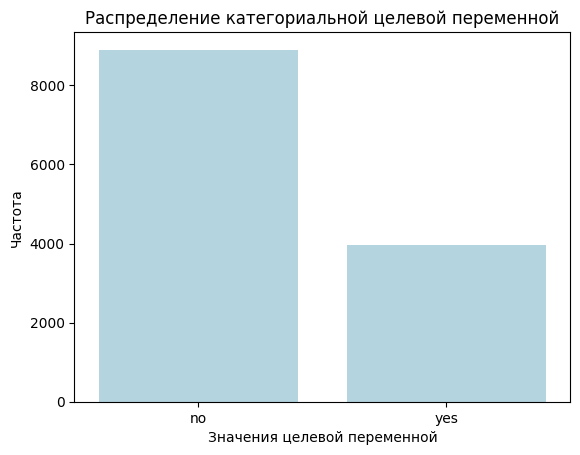

In [5]:
sns.countplot(x='y', data=concatenated_df, color = 'lightblue')
plt.xlabel('Значения целевой переменной')
plt.ylabel('Частота')
plt.title('Распределение категориальной целевой переменной')
plt.show()

<b>1.4 Создайте переменные <i>numeric_features, categorical_features</i>, в которые запишите название столбцов числовых и категориальных признаков</b>


In [6]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

concatenated_df.info()
# valid_prep.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17161 entries, 0 to 17160
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         17161 non-null  int64  
 1   age        16573 non-null  float64
 2   job        17161 non-null  object 
 3   marital    17161 non-null  object 
 4   education  17161 non-null  object 
 5   default    17161 non-null  object 
 6   balance    17156 non-null  float64
 7   housing    17161 non-null  object 
 8   loan       17161 non-null  object 
 9   contact    17161 non-null  object 
 10  day        17161 non-null  int64  
 11  month      17156 non-null  object 
 12  campaign   17161 non-null  int64  
 13  pdays      17161 non-null  int64  
 14  previous   17161 non-null  int64  
 15  poutcome   17161 non-null  object 
 16  y          12870 non-null  object 
dtypes: float64(2), int64(5), object(10)
memory usage: 2.2+ MB


In [7]:
numeric_features = ['ID','age','balance', 'day', 'campaign','previous']
categorical_features = ['job', 'marital', 'education','default', 'housing', 'loan', 'contact', 'month', 'poutcome']

<b>1.5 Отобразите распределения всех признаков</b> (можно в одной фигуре все числовые, в другой все категориальные)

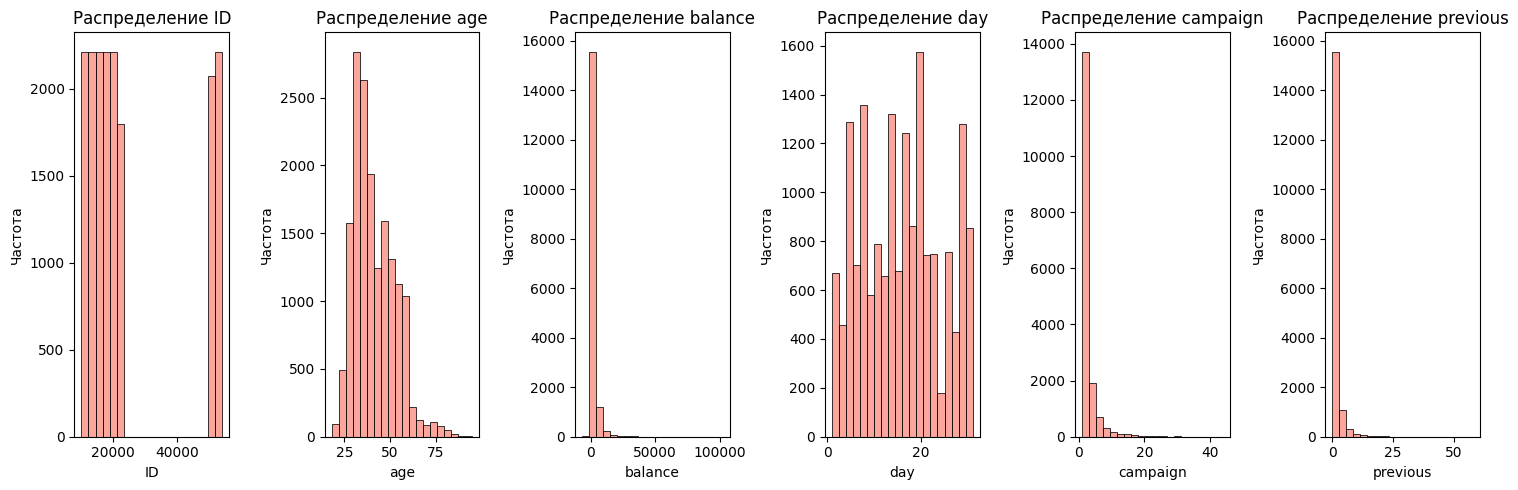

In [8]:
#your code
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(15, 5))

for i, feature in enumerate(numeric_features):
    sns.histplot(concatenated_df[feature], ax=axes[i], bins=20, color='salmon', alpha=0.7)
    axes[i].set_xlabel(f'{feature}')
    axes[i].set_ylabel('Частота')
    axes[i].set_title(f'Распределение {feature}')

plt.tight_layout()


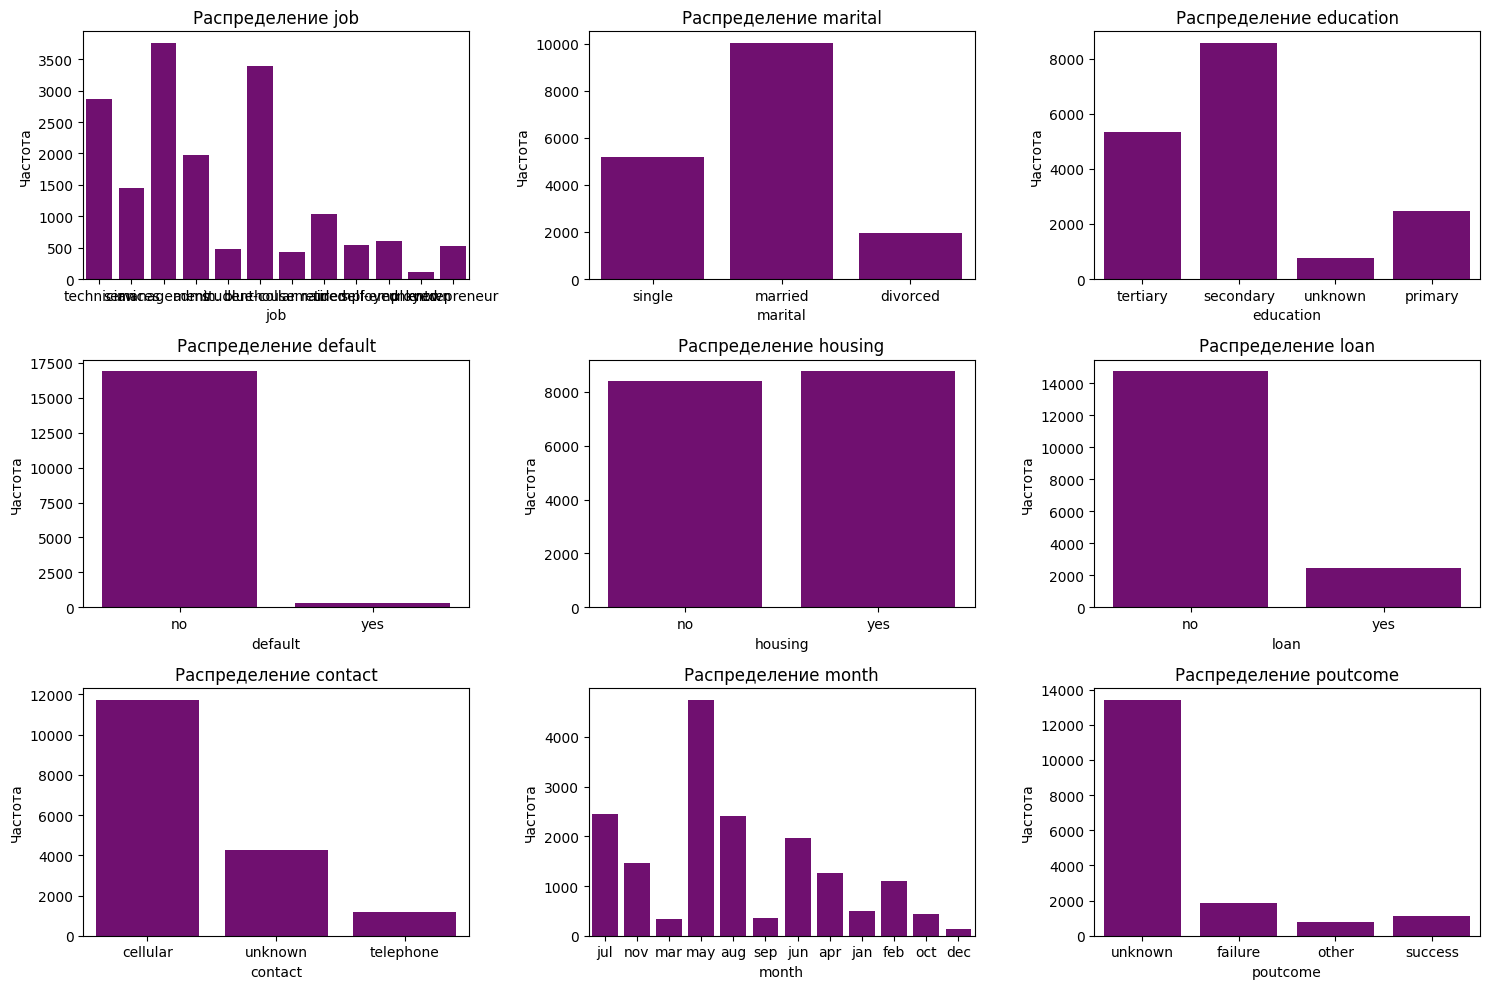

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=concatenated_df, ax=axes[i // 3, i % 3], color = 'purple')
    axes[i // 3, i % 3].set_xlabel(f'{feature}')
    axes[i // 3, i % 3].set_ylabel('Частота')
    axes[i // 3, i % 3].set_title(f'Распределение {feature}')

plt.tight_layout()


 <b>1.6 Попробуйте графически подчеркнуть зависимости</b> (матрицы корреляций, боксплоты, скаттерплоты и тд)

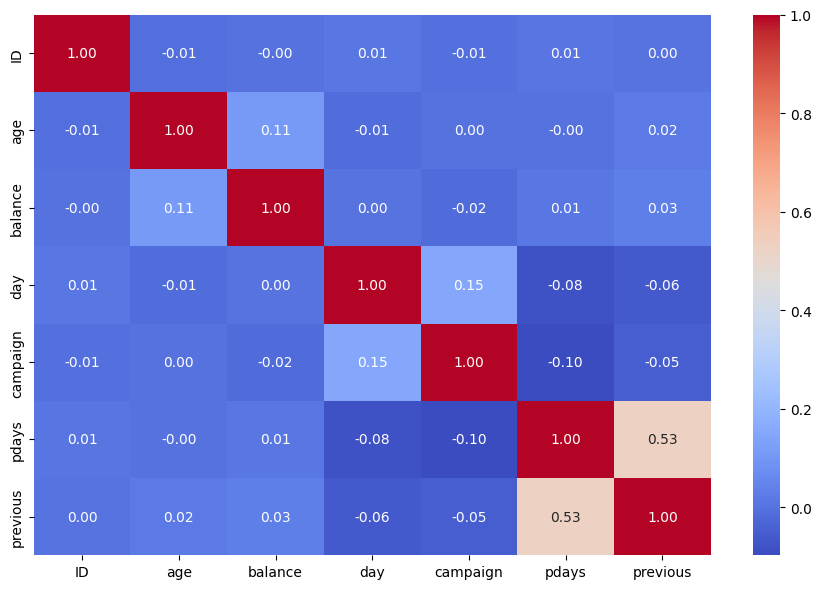

In [41]:
corr = concatenated_df.select_dtypes('number').corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr , fmt = '0.2f', cmap = 'coolwarm', annot=True)
plt.tight_layout()

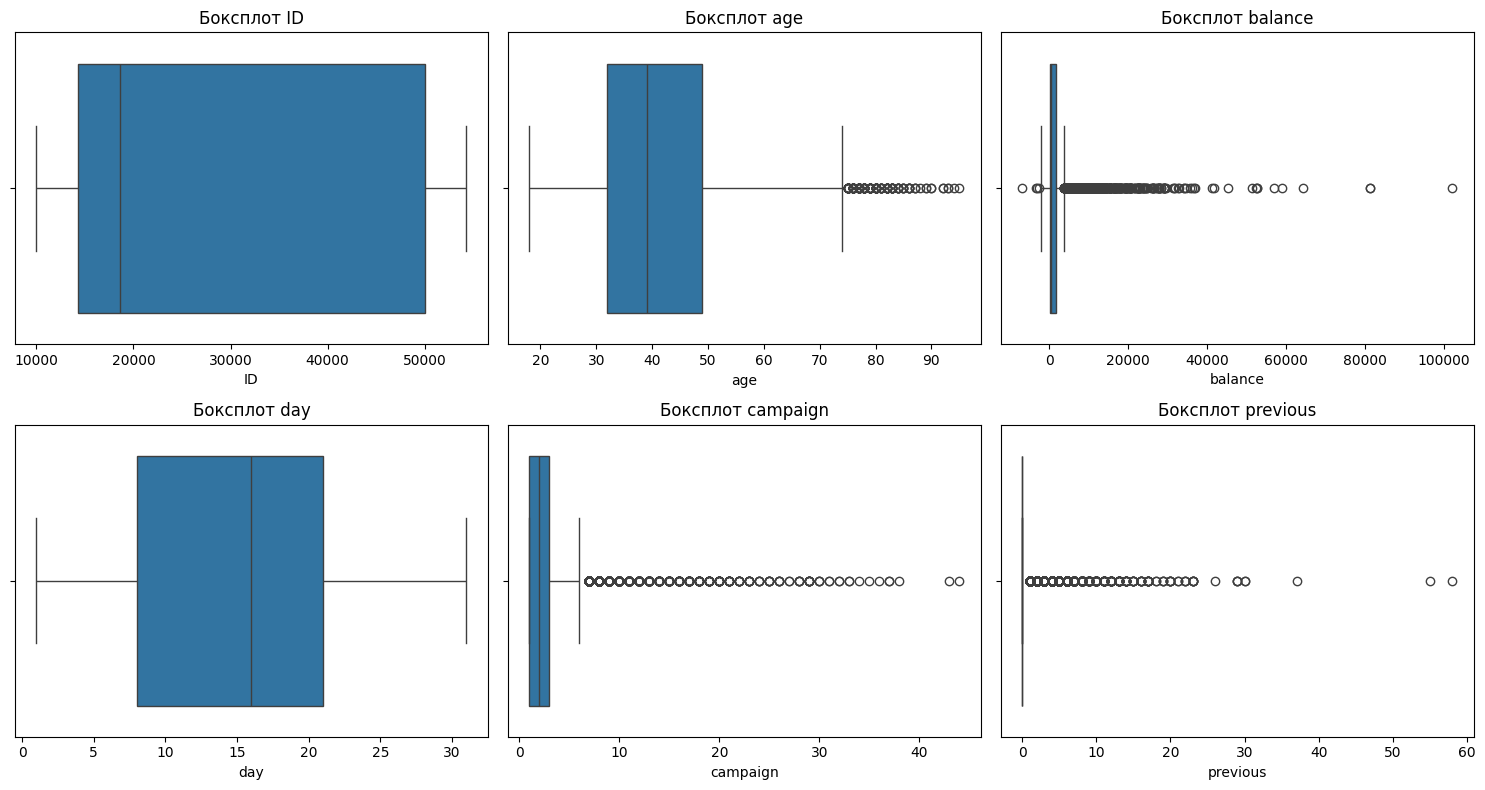

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for i, feature in enumerate(numeric_features):
    sns.boxplot(x=concatenated_df[feature], ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_xlabel(f'{feature}')
    axes[i // 3, i % 3].set_title(f'Боксплот {feature}')

plt.tight_layout()

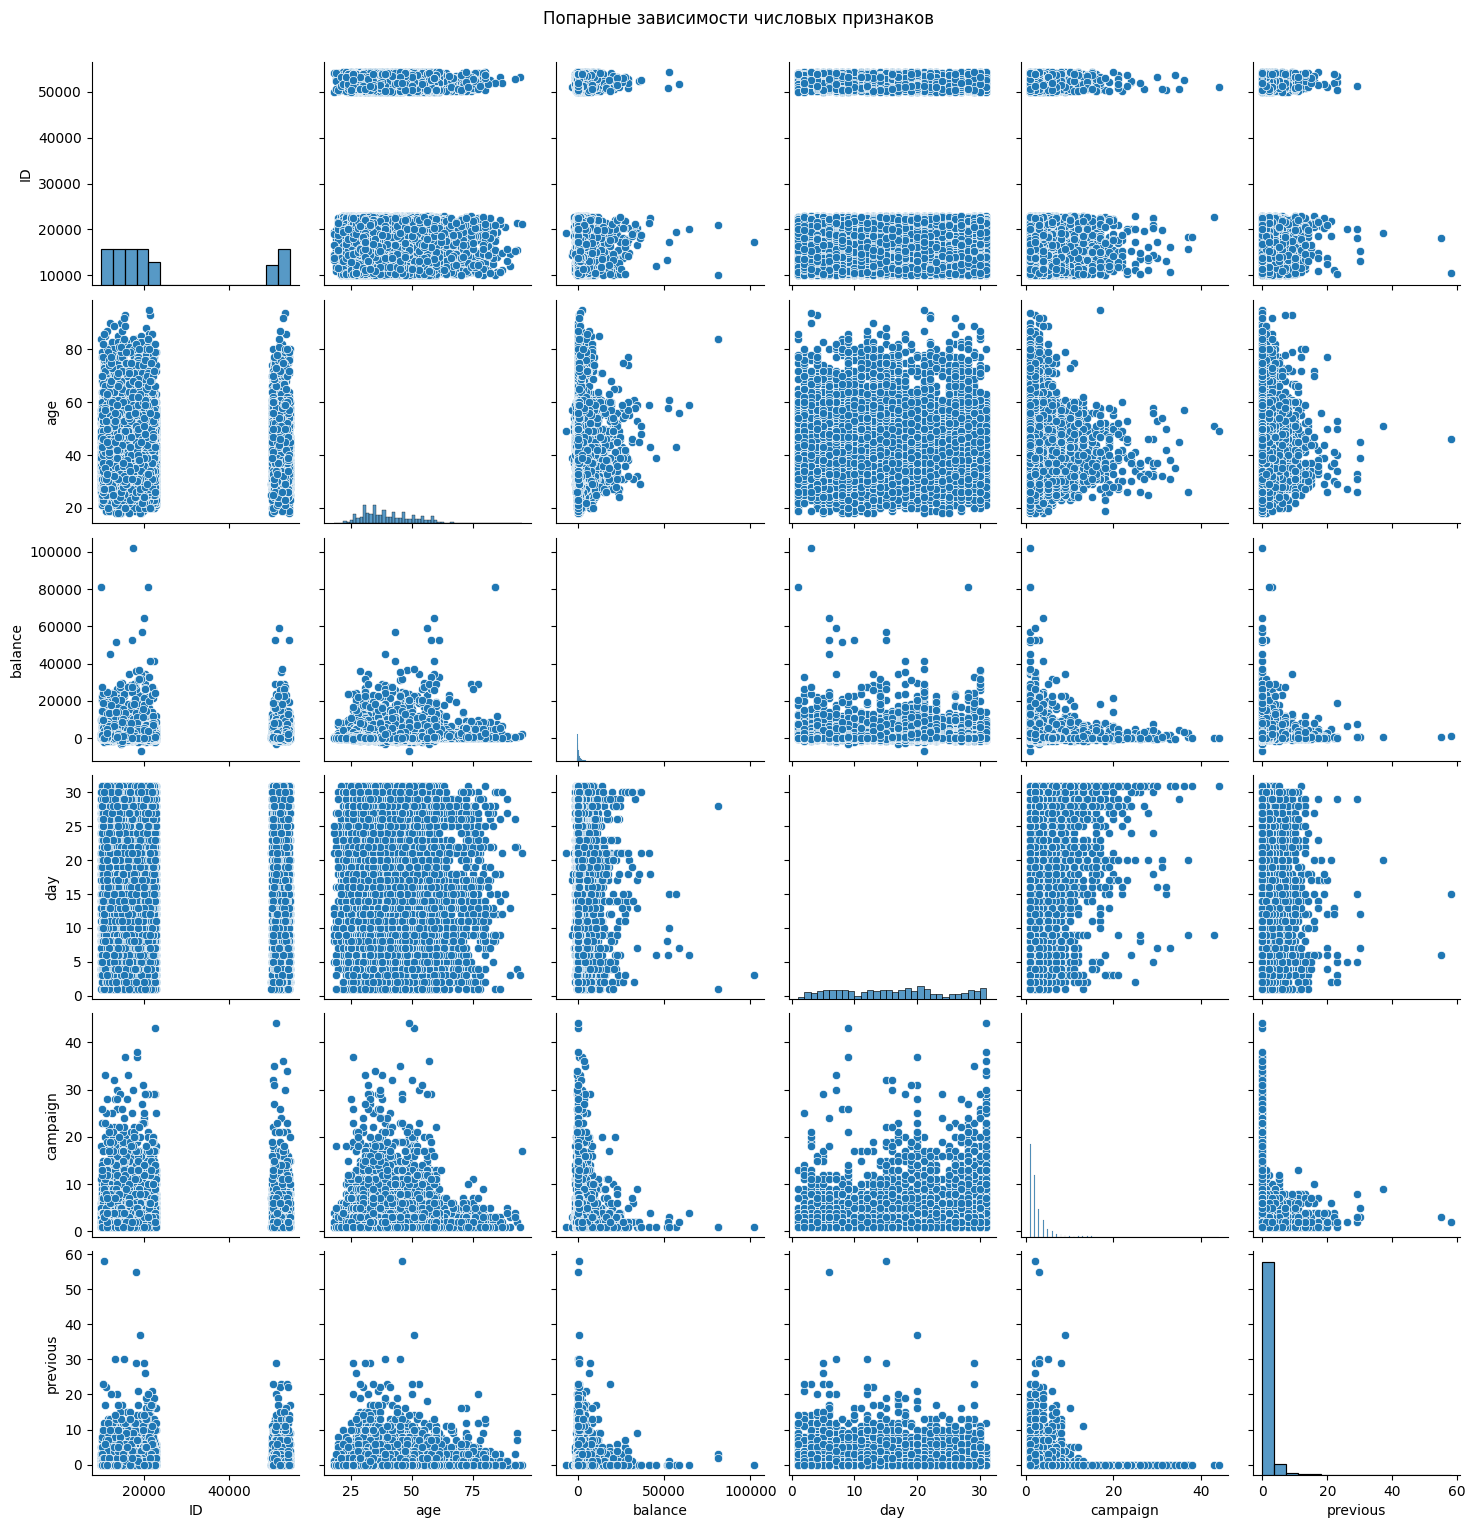

In [43]:
sns.pairplot(concatenated_df[numeric_features])
plt.suptitle('Попарные зависимости числовых признаков', y=1.02)
#выглядит так себе

### 2. Работа с пропусками(imputing)  

* <b>какими способами можно обработать пропуски:</b>
    - в категориальных переменных
      > можно обрабатывать пропуски с помощью исп-ния моды, либо создавать как-то новые фичи на основании старых
    - в числовых переменных
      > интерполяция, среднее, медиана, предсказать с помощью ML-модельки
    
* <b>Какие плюсы у того или иного способа</b>

  > Замена на моду: просто и быстро +  сохранение структуры данных.
Создать новые фичи: сохраняется информация о наличии пропусков.
Замена на среднее/медиану (числовые): просто и быстро , не смещает статистику.
Интерполяция (числовые): учитывает структуру данных. Подходит для последовательных данных.
Применение модели машинного обучения: Учитывает сложные взаимосвязи между переменными, но требует больше вычислительных ресурсов. 



* <b>Заполните пропуски способом, который считаете нужным</b>

In [69]:
concatenated_df


,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,13829,NaN,technician,single,tertiary,no,NaN,no,no,cellular,11,NaN,2,-1,0,unknown,no
1,22677,NaN,services,single,secondary,no,NaN,yes,yes,unknown,5,NaN,3,-1,0,unknown,no
2,10541,NaN,management,single,secondary,no,NaN,no,no,cellular,14,NaN,2,-1,0,unknown,no
3,13689,NaN,technician,married,unknown,no,NaN,yes,no,cellular,10,NaN,1,-1,0,unknown,no
4,11304,NaN,admin.,single,secondary,no,NaN,no,yes,unknown,2,NaN,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17156,50332,47.0,admin.,married,secondary,no,520.0,no,no,telephone,9,feb,6,-1,0,unknown,NaN
17157,51293,33.0,technician,married,secondary,no,133.0,no,no,cellular,12,nov,2,192,1,success,NaN
17158,54023,40.0,admin.,married,secondary,no,2574.0,yes,no,cellular,20,nov,1,-1,0,unknown,NaN
17159,53775,39.0,blue-collar,married,secondary,no,2467.0,no,no,cellular,19,jul,2,276,3,other,NaN


In [10]:
FILL_MEAN_ = ['age','balance']
FILL_MODE = ['month']    # для категор фичей

#target = ['job', 'marital', 'education','default', 'housing', 'loan', 'contact', 'month', 'poutcome']
STANDARD_SCALER_FEATURES = ['ID','age','balance', 'day', 'campaign','previous']
ONE_HOT = ['job', 'marital', 'education','default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [11]:
test_imputer = ColumnTransformer(
    transformers = [
        ('mean_imputer', SimpleImputer(strategy='mean', missing_values=np.nan), FILL_MEAN_),
        ('mode_imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan), FILL_MODE),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

test_encoder = ColumnTransformer(
    [
        #('target_encoding_columns', TargetEncoder(), target)
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), ['job','marital', 'education','default', 'housing', 'loan', 'contact', 'month', 'poutcome']),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

test_scaler= ColumnTransformer(
    [
        ('scaling_num_columns', StandardScaler(), STANDARD_SCALER_FEATURES)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

test_preprocessor = Pipeline(
    [
        ('imputer', test_imputer),
        ('encoder', test_encoder),
        ('scaler', test_scaler)
    ]
)

In [89]:
done_df = test_preprocessor.fit_transform(concatenated_df)
done_df
done_train = test_preprocessor.fit_transform(df_train)
done_test = test_preprocessor.fit_transform(df_test)

### 3. Статистика



* <b>Что такое t-test/z-test и для чего он применяется?</b>

t-test сравнивает ср.знач. двух выборок, чтобы определить вероятность того, что эти выборки имеют одинаковые средние значения
z-test в отличие от ттеста применяется, когда известны параметры ГС, такие как среднее и стандартное отклонение.

* <b>

Примените t-test для проверки значимости признака `balance` в разрезе класса</b> и прокомментируйте полученный результат

> комментарий по результатам теста

* Если считаете необходимым, можете описать и остальные фичи стат.тестами. 

### 4. Кодирование категориальных перменных(encoding)

* <b>Для чего нужно кодировать категориальные переменные?</b>
    > для последующей обработки их МЛ алгоритмами, которые принимают только цифры.
* <b>Какие способы кодирования категориальных переменных вам известно</b>
    > One-hot, target, label, ordinal, binary

* <b>Закодируйте переменные соответствующим способом</b>

In [ ]:
#your code
#pipeline выше

### 5. Масштабирование данных (Scaling)

* <b>Какие основные Scaler'ы знаете</b>
    > стандарт скейлер(делает так, чтоб ср.знач был 0, а стандарт. откл. 1), мин макс скейлер(преобразует в задан. диапозон 0,1), robust скейлер(учитывает выбросы), MaxAbsScaler (масштабирует каждый признак по его максимальному абсолют. значению.) 
* <b>Для чего это нужно</b>
    > чтобы модели были более производительными, + обрабатываются выбросы, нет такого большого разброса в данных. Интерпретируются веса признаков.
* <b>Для чего это нужно</b>
    > ответ тут

* Вспомните структуры пройденных нами алгоритмов. Каким алгоритмам необходимы нормализованные данные, а каким  нет?
    > градиентный спуск, метод ближ.соседей, метод опорных векторов, метод главных компонент требуют нормализации, тк основаны на расстояниях или градииентном спуске

* <b>отмасштабируйте свои признаки</b>

In [ ]:
# your code
#pipeline выше

### 6.Модели

* Какие знаете модели машинного обучения? В чем плюсы и минусы каждого (🔥)
    > дерево решений(хорошая интерпритация, но склонны к переобучению), случайный лес(не склонен к переобучению, но не так интерпритируем как дерево решений), линейная и логистическая регрессии(простота и интерпретируемость, но чувствительны к выбросам), градиентный бустинг(мощный и эффективный, но могут требовать настройку гиперпараметров через оптюну). 

* __Boosting vs Bagging__. В чем разница, плюсы и минусы каждого друг перед другом.(🔥🔥🔥)
    > в бэггинге все модели независимо друг от друга обучаются, а их результаты потом усредняются(регрессия), либо проводится голосование (для классификации)
    в бустинге веса оишбочно предсказанных точек увеличиваются, а след. модель фокусируется на коррекции.Предсказания каждой модели взвешиваются при формировании итогового предсказания.
    плюсы бэггинга: бэггинг уменьшает дисперсию модели, делая её менее склонной к переобучению. Он более стабильный благодаря усреднению результатов моделей.
    минусы бэггинга: не всегда эффективен при сложных зависимостях в данных. Имеет сложную интерпретацию из-за усредненения рез-тов моделей.
    плюсы бустинга: имеет достаточно высокую точность. эффективен для сложных зависимостей
    минусы бустинга:чувствителен к выбросам, склонен к переобучению


* Выберите модели, которые считаете нужными. Тюнинг, валидирование результата и отбор признаков на вас. Тестовая выборка ждет вас на стримлите, метрика качества __ROC-AUC__, но это всего лишь одна метрика, по которой мы будем оценивать эффективность. Можете смотреть множество метрик, это полезно, не стесняйтесь :)

* Как можно попытаться проинтепретировать ROC-AUC? PR-AUC? (🔥)


это метрики для оценки кач-ва бинарной классификации. 
roc-auc 1: модель идеально классифицирует.
0.5: случайное угадывание
<0.5 модель работает хуже, чем случайное угадывание


pr-auc 1:модель идеально предсказывает класссы
0,5 модель не дает никакой нормальной информации о классах
<0.5 модель хуже случайного угадывания()


In [34]:
target_column = 'y'
# df_done_test = done_df.copy()

# df_done_test = df_done_test.drop(target_column, axis=1)

# df_done_test.to_csv('test_done.csv', index=False)

# df_done_test.info()

In [24]:
train_done = done_df.dropna(subset=[target_column]).copy()

train_done.to_csv('train_done.csv', index=False)
train_done.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12870 entries, 0 to 12869
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   12870 non-null  float64
 1   age                  12870 non-null  float64
 2   balance              12870 non-null  float64
 3   day                  12870 non-null  float64
 4   campaign             12870 non-null  float64
 5   previous             12870 non-null  float64
 6   job_admin.           12870 non-null  float64
 7   job_blue-collar      12870 non-null  float64
 8   job_entrepreneur     12870 non-null  float64
 9   job_housemaid        12870 non-null  float64
 10  job_management       12870 non-null  float64
 11  job_retired          12870 non-null  float64
 12  job_self-employed    12870 non-null  float64
 13  job_services         12870 non-null  float64
 14  job_student          12870 non-null  float64
 15  job_technician       12870 non-null  floa

In [28]:
label_encoder = LabelEncoder()

train_done[target_column] = label_encoder.fit_transform(train_done[target_column])


In [36]:
X, y = train_done.drop('y', axis=1), train_done['y']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [81]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

    catboost_model = CatBoostClassifier(
        iterations=params['iterations'],
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        loss_function='Logloss',
        random_state=42
    )

    catboost_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    probabilities = catboost_model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, probabilities)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print('ROC AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2024-01-12 17:13:02,856] A new study created in memory with name: no-name-0586094c-cea6-45e8-a382-27914d863870


[I 2024-01-12 17:13:03,180] Trial 0 finished with value: 0.7710409883963604 and parameters: {'iterations': 98, 'depth': 4, 'learning_rate': 0.037774887650926715}. Best is trial 0 with value: 0.7710409883963604.
[I 2024-01-12 17:13:03,728] Trial 1 finished with value: 0.7705375711843552 and parameters: {'iterations': 54, 'depth': 9, 'learning_rate': 0.01584250185097356}. Best is trial 0 with value: 0.7710409883963604.
[I 2024-01-12 17:13:04,570] Trial 2 finished with value: 0.7900586896634327 and parameters: {'iterations': 203, 'depth': 8, 'learning_rate': 0.06071803517980497}. Best is trial 2 with value: 0.7900586896634327.
[I 2024-01-12 17:13:04,836] Trial 3 finished with value: 0.7876762595411535 and parameters: {'iterations': 128, 'depth': 4, 'learning_rate': 0.07748994445433914}. Best is trial 2 with value: 0.7900586896634327.
[I 2024-01-12 17:13:06,079] Trial 4 finished with value: 0.7914974393594587 and parameters: {'iterations': 279, 'depth': 10, 'learning_rate': 0.0907148746178

Best trial:
ROC AUC: 0.7959007974099603
Best hyperparameters: {'iterations': 266, 'depth': 7, 'learning_rate': 0.06475794315762701}


In [91]:
from sklearn.metrics import roc_auc_score
# Инициализация модели
catboost_model = CatBoostClassifier(iterations=266, depth=7, learning_rate=0.06475794315762701, loss_function='Logloss', random_state=42)

# Обучение модели
catboost_model.fit(X_train, y_train)

# Прогнозирование вероятностей на тестовом наборе
# y_probabilities = catboost_model.predict_proba(X_test)[:, 1]

probabilities = catboost_model.predict_proba(done_test)[:, 1]

# roc_auc = roc_auc_score(done_test, probabilities)
# print(f'ROC AUC: {roc_auc}')

0:	learn: 0.6719431	total: 9.2ms	remaining: 2.44s
1:	learn: 0.6522618	total: 14.9ms	remaining: 1.96s
2:	learn: 0.6368120	total: 19.7ms	remaining: 1.73s
3:	learn: 0.6218816	total: 23.6ms	remaining: 1.54s
4:	learn: 0.6090855	total: 28.8ms	remaining: 1.5s
5:	learn: 0.5980748	total: 34.7ms	remaining: 1.5s
6:	learn: 0.5874852	total: 38.7ms	remaining: 1.43s
7:	learn: 0.5787639	total: 42.2ms	remaining: 1.36s
8:	learn: 0.5706973	total: 46.2ms	remaining: 1.32s
9:	learn: 0.5634851	total: 50ms	remaining: 1.28s
10:	learn: 0.5572200	total: 53.9ms	remaining: 1.25s
11:	learn: 0.5515483	total: 57.9ms	remaining: 1.22s
12:	learn: 0.5461598	total: 61.6ms	remaining: 1.2s
13:	learn: 0.5416871	total: 65.4ms	remaining: 1.18s
14:	learn: 0.5377996	total: 69.1ms	remaining: 1.16s
15:	learn: 0.5337771	total: 72.8ms	remaining: 1.14s
16:	learn: 0.5301036	total: 76.4ms	remaining: 1.12s
17:	learn: 0.5266242	total: 80.7ms	remaining: 1.11s
18:	learn: 0.5237784	total: 84.7ms	remaining: 1.1s
19:	learn: 0.5206445	total: 8

In [93]:
# submit = pd.DataFrame()
# submit['ID'] = df_test['ID']
# submit['predict'] = 
# submit
len(probabilities)


4291

In [98]:

predictions =catboost_model.predict_proba(done_test)[:, 1]
submission = pd.DataFrame(df_test["ID"])
submission["predict"] = list(predictions)
submission.to_csv('submission.csv', index=False)



In [78]:
X

,ID,age,balance,day,campaign,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,pdays
0,-0.729706,0.000000,6.971822e-17,-0.560481,-0.226470,-0.339641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
1,-0.169965,0.000000,6.971822e-17,-1.278104,0.123377,-0.339641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
2,-0.937711,0.000000,6.971822e-17,-0.201670,-0.226470,-0.339641,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
3,-0.738563,0.000000,6.971822e-17,-0.680085,-0.576318,-0.339641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
4,-0.889443,0.000000,6.971822e-17,-1.636915,-0.576318,-0.339641,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,-0.717433,0.535802,-9.617555e-02,1.711990,-0.576318,2.107083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,87
12866,-0.512718,-0.903571,-4.199705e-01,0.635557,-0.226470,0.639048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,93
12867,-0.642974,-0.363806,-5.048858e-02,0.276745,-0.576318,0.639048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,172
12868,-0.733122,0.085998,-3.071328e-01,1.472783,-0.226470,-0.339641,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1


### 7.Классификация

In [26]:
import pandas as pd

assert len(pd.read_csv('data/test.csv')) == len(pd.read_csv('data/submission.csv')), \
    'Lengths of files are mismatch!'